In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
from lsst.sims.photUtils import Bandpass, BandpassDict

In [3]:
import lsst.sims.skybrightness as sb
from lsst.sims.photUtils import Sed, calcM5, PhotometricParameters

In [4]:
from lsst.utils import getPackageDir

In [5]:
import os

In [6]:
results = os.path.join('/Users/rbiswas/data/LSST/OpSimData/m5calcs/', 'combined_results.hdf')
df = pd.read_hdf(results)

In [7]:
df.head()

,fiveSigmaDepth,fieldm5,skymags,airmass,filter,opsimm5,band,filtSkyBrightness
obsHistID,,,,,,,,
1,21.021236,20.941226,16.769984,1.463594,y,20.761463,y,16.503054
2,21.026646,20.999290,16.879624,1.454958,y,20.813999,y,16.598370
3,21.030520,21.057899,16.971386,1.448796,y,20.861257,y,16.686202
4,21.032718,21.100468,17.054457,1.445307,y,20.902624,y,16.765577
5,21.033233,21.139332,17.132519,1.444491,y,20.939806,y,16.839953


In [8]:
def get_terms(i, numcols, ax=None):
    row = i // numcols
    col = i % numcols
    if ax is None:
        return row, col
    else:
        return ax[row, col]

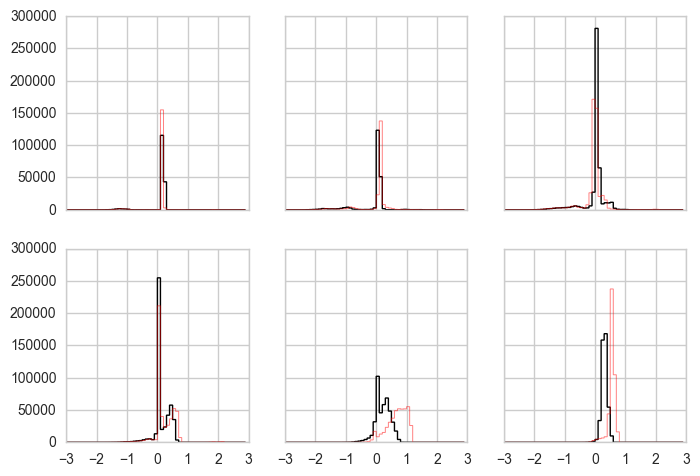

In [44]:
mbins = np.arange(-3., 3., 0.1)
fig_m5, axm5 = plt.subplots(2, 3, sharex=True, sharey=True)
for i, b in enumerate('ugrizy'):
    tmp = df.query('band == @b')
    _x = get_terms(i, 3, axm5)
    _ = _x.hist(tmp.fieldm5 - tmp.opsimm5, bins=mbins, histtype='step', lw=1, alpha=1,
                color='k')
    _ = _x.hist(tmp.fieldm5 - tmp.fiveSigmaDepth, bins=mbins, histtype='step', lw=0.7, alpha=0.5,
                color='r')
    

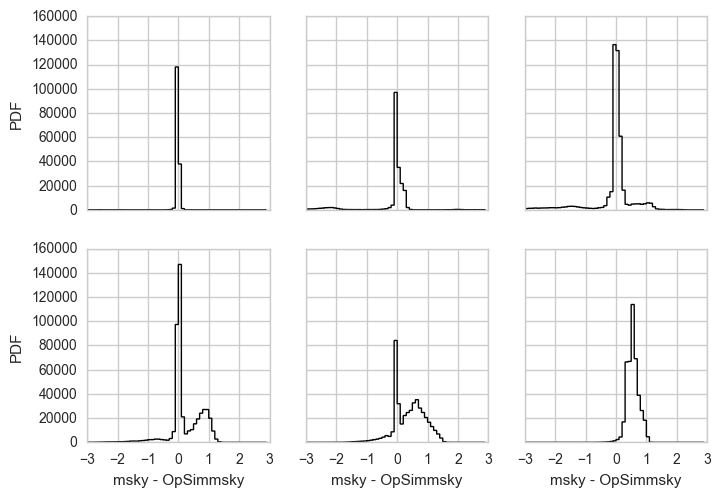

In [45]:
mbins = np.arange(-3., 3., 0.1)
fig_m, axm = plt.subplots(2, 3, sharex=True, sharey=True)
for i, b in enumerate('ugrizy'):
    tmp = df.query('band == @b')
    _x = get_terms(i, 3, axm)
    _ = _x.hist(tmp.skymags - tmp.filtSkyBrightness, bins=mbins, histtype='step', lw=1, alpha=1,
                color='k')
axm[1, 0].set_xlabel('msky - OpSimmsky')
axm[1, 1].set_xlabel('msky - OpSimmsky')
axm[1, 2].set_xlabel('msky - OpSimmsky')
axm[0, 0].set_ylabel('PDF')
axm[1, 0].set_ylabel('PDF')

In [ ]:
fig_m.savefig('msky.pdf')

def atmTransName(airmass):
    """
    return filename for atmospheric transmission with aerosols for airmass
    closest to input
        
    Parameters
    ----------
    airmass : airmass
    """
    l = np.arange(1.0, 2.51, 0.1)
    idx = np.abs(l - airmass).argmin()
    a = np.int(10*l[idx])
    baseline = getPackageDir('THROUGHPUTS')
    fname = os.path.join(baseline, 'atmos', 'atmos_{}_aerosol.dat'.format(a))
    return fname

def mCalcs(airmass, bandName, ra, dec, expMJD,  FWHMeff, hwbpdict, photparams=None, sm=None):
    """
    sm : 
    """
    if photparams is None:
        photparams = PhotometricParameters()
    if sm is None:
        sm = SkyModel(observatory='LSST', mags=False, preciseAltAz=True)
    # Obtain full sky transmission at airmass
    # Note that this method is not interpolating but choosing the atmospheric transmission from
    # Modtran simulations of the closest airmass in a sequence of np.arange(1., 2.51, 0.1)
    fname = atmTransName(airmass)
    print(fname)
    atmTrans = np.loadtxt(fname)
    wave, trans = hwbpdict[bandName].multiplyThroughputs(atmTrans[:, 0], atmTrans[:, 1])
    bp = Bandpass(wavelen=wave, sb=trans)
    # Set the observing condition
    sm.setRaDecMjd(lon=[ra], lat=[dec], filterNames=[bandName],
                   mjd=expMJD, degrees=False, azAlt=False)
    # Get the sky sed
    wave, spec = sm.returnWaveSpec()
    sed = Sed(wavelen=wave, flambda=spec[0])
    m5 = calcM5(sed, bp, hwbpdict[bandName], photparams, FWHMeff)
    # Get the sky magnitude only in the band concerned
    m = sm.returnMags(bandpasses=hwbpdict)[bandName][0]
    return m5, m
    

In [10]:
from brightness import mCalcs, atmTransName

In [11]:
df.head()

,fiveSigmaDepth,fieldm5,skymags,airmass,filter,opsimm5,band,filtSkyBrightness
obsHistID,,,,,,,,
1,21.021236,20.941226,16.769984,1.463594,y,20.761463,y,16.503054
2,21.026646,20.999290,16.879624,1.454958,y,20.813999,y,16.598370
3,21.030520,21.057899,16.971386,1.448796,y,20.861257,y,16.686202
4,21.032718,21.100468,17.054457,1.445307,y,20.902624,y,16.765577
5,21.033233,21.139332,17.132519,1.444491,y,20.939806,y,16.839953


## Examples

I copied the values of expMJD, FWHMeff, fieldRA, fieldDec from a sqlite query by hand (will change in a later iteration). Comparison of m5 and msky values from the dataframe for the first two rows is quite good. 

In [12]:
tot, hwbpdict = BandpassDict.loadBandpassesFromFiles()

In [13]:
from lsst.sims.skybrightness import SkyModel

In [14]:
mCalcs(1.464, 'y', 1.676483, -1.082473, 59580.033829, 1.263038, hwbpdict)

/Users/rbiswas/soft/LSST/DarwinX86/throughputs/2016.12.13/atmos/atmos_15_aerosol.dat


/Users/rbiswas/soft/LSST/DarwinX86/healpy/1.8.1.lsst2+5/lib/python/healpy-1.8.1-py2.7-macosx-10.6-x86_64.egg/healpy/pixelfunc.py:1045: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if phi == None:


(20.941363038245818, 16.770260090102994)

In [15]:
mCalcs(1.454958, 'y', 1.69412, -1.033972, 59580.034275, 1.258561, hwbpdict)

/Users/rbiswas/soft/LSST/DarwinX86/throughputs/2016.12.13/atmos/atmos_15_aerosol.dat


(20.999420248946787, 16.879887035946521)

In [16]:
df['diffmsky'] = df['skymags'] - df['filtSkyBrightness']

In [17]:
df.query('diffmsky > 3.3')

,fiveSigmaDepth,fieldm5,skymags,airmass,filter,opsimm5,band,filtSkyBrightness,diffmsky
obsHistID,,,,,,,,,
994149,23.122255,24.599756,22.219119,1.008652,g,23.035296,g,18.910191,3.308928
1652674,23.772172,25.166984,22.257659,1.004192,g,23.613380,g,18.940178,3.317481
1652675,23.773800,25.167476,22.257760,1.003477,g,23.613950,g,18.940088,3.317672
1652676,23.774690,25.167611,22.257858,1.003324,g,23.614575,g,18.941096,3.316762
1652677,23.775582,25.167743,22.257955,1.003176,g,23.614991,g,18.941683,3.316272
1652678,23.776471,25.167868,22.258043,1.003034,g,23.615402,g,18.942273,3.315770
1652679,23.777359,25.167985,22.258122,1.002897,g,23.615811,g,18.942868,3.315254
1652680,23.778247,25.168098,22.258199,1.002765,g,23.616220,g,18.943470,3.314729
1652681,23.779131,25.168206,22.258273,1.002639,g,23.616626,g,18.944079,3.314194


In [58]:
mCalcs(1.008652, 'g', 0.925184, -0.4789, 61044.077855, 1.086662, hwbpdict=hwbpdict)

/Users/rbiswas/soft/LSST/DarwinX86/throughputs/2016.12.13/atmos/atmos_10_aerosol.dat


(23.060145140066918, 18.890032323915136)

In [18]:
from opsimsummary import OpSimOutput

In [19]:
opsout = OpSimOutput.fromOpSimDB('/Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db')

 reading from database sqlite:////Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db
SELECT * FROM Summary WHERE PROPID in (56, 54)


/usr/local/miniconda/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
row = opsout.summary.ix[994149]

In [21]:
mCalcs(row.airmass, row['filter'], row.fieldRA, row.fieldDec, row.expMJD, row.FWHMeff, hwbpdict=hwbpdict)

/Users/rbiswas/soft/LSST/DarwinX86/throughputs/2016.12.13/atmos/atmos_10_aerosol.dat


(23.060145140066918, 18.890032323915136)

In [26]:
sb.__version__

'2.3.3.sims'

In [27]:
np.__version__

'1.11.1'

In [ ]:
Sed.writeSED()

In [28]:
laptop = np.loadtxt('skySED_laptop.csv')

In [29]:
lsstuw = np.loadtxt('skySED.csv')

In [38]:
laptop.shape

(17001, 2)

In [40]:
import healpy as hp

In [42]:
hp.__file__

'/Users/rbiswas/soft/LSST/DarwinX86/healpy/1.8.1.lsst2+5/lib/python/healpy-1.8.1-py2.7-macosx-10.6-x86_64.egg/healpy/__init__.pyc'

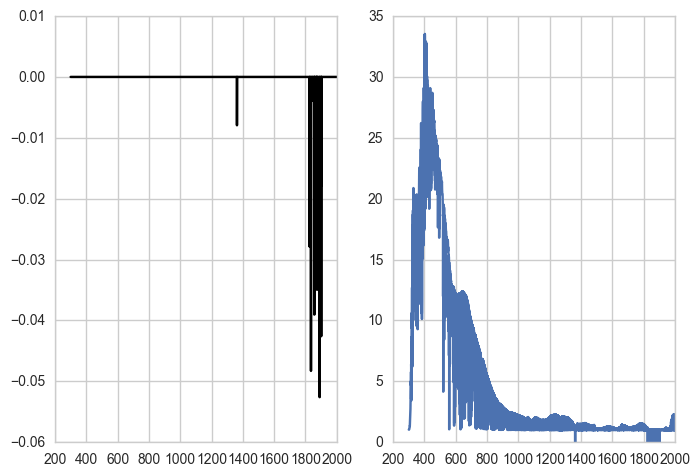

In [39]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(laptop[:, 0], laptop[:, 1] - lsstuw[:,1], 'k-')
#ax[0].plot(lsstuw[:, 0], lsstuw[:, 1])
ax[1].plot(laptop[:, 0], laptop[:, 1]/lsstuw[:, 1])